# Library

In [248]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time

# from astropy.cosmology import WMAP9 as cosmo
# from astropy.constants import c
# from astropy import units as u
# from astropy.cosmology import z_at_value
import inspect

import sys
sys.path.append('..')
from util.helper import *
from util.sdtpy import *
register_custom_filters_on_speclite('../util')

Use `med25nm`, `med50nm`, `broad` as `group_name`


# Setting

- Define `speclite` object

In [249]:
register_custom_filters_on_speclite('../util')
filterset = [f"{group}-{filte}" for filte, _, group in filterlist_med25nm]
bands = speclite.filters.load_filters(*filterset)

Use `med25nm`, `med50nm`, `broad` as `group_name`


## Kilonova
- GW170817-like morphology model

In [250]:
import pickle
with open('../model/gw170817-like.interp.pkl', 'rb') as f:
	interp = pickle.load(f)
# interp = interp_gw170817like_kn(path_kntable='/Users/paek/Research/7DT/7dtpy/3.table/kn_sim_cube_lite', path_pickle=None)
# lamarr = np.arange(1003, 127695.+1, 1)

In [251]:
if 'med' in bands.names[0]:
    #    Medium-band
    bandwidth = 250 # [AA]
else:
    #	Broad-band
	bandwidth = 1000 # [AA]

# lammin = bands.effective_wavelengths.min().value-bandwidth*2
# lammax = bands.effective_wavelengths.max().value+bandwidth*2
lammin = 3000
lammax = 10000

lamstep = bandwidth/10
lamarr = np.arange(lammin, lammax+lamstep, lamstep)

print(f"lam: {lammin:.3f} - {lammax:.3f} AA")
print(f"lamstep: {lamstep:g} AA")
print(f"n_lam: {len(lamarr)}")

lam: 3000.000 - 10000.000 AA
lamstep: 25 AA
n_lam: 281


- Model parameters

In [252]:
mdarr = np.array([0.001, 0.003, 0.01, 0.03, 0.1])
vdarr = np.array([0.05, 0.15, 0.3])
mwarr = np.array([0.001, 0.003, 0.01, 0.03, 0.1])
vwarr = np.array([0.05, 0.15, 0.3])
#	Viewing angle
angarr = np.linspace(0, 180, 54)

#	Phase
phasearr = np.array([0.25, 0.5, 1.0])

#	Redshift
zarr = np.array([1e-4, 1e-3, 1e-2, 1e-1, 1e0])

mdmin = np.min(mdarr)
mdmax = np.max(mdarr)
vdmin = np.min(vdarr)
vdmax = np.max(vdarr)
mwmin = np.min(mwarr)
mwmax = np.max(mwarr)
vwmin = np.min(vwarr)
vwmax = np.max(vwarr)
angmin = np.min(angarr)
angmax = np.max(angarr)
phasemin = np.min(phasearr)
phasemax = np.max(phasearr)
zmin = np.min(zarr)
zmax = np.max(zarr)

print(f"md : {np.mean(mdarr):.3} ({mdmin:.3} - {mdmax:.3})")
print(f"vd : {np.mean(vdarr):.3} ({vdmin:.3} - {vdmax:.3})")
print(f"mw : {np.mean(mwarr):.3} ({mwmin:.3} - {mwmax:.3})")
print(f"vw : {np.mean(vwarr):.3} ({vwmin:.3} - {vwmax:.3})")
print(f"ang: {np.mean(angarr):.3} ({angmin:.3} - {angmax:.3})")
print(f"phase: {np.mean(phasearr):.3} ({phasemin:.3} - {phasemax:.3})")

md : 0.0288 (0.001 - 0.1)
vd : 0.167 (0.05 - 0.3)
mw : 0.0288 (0.001 - 0.1)
vw : 0.167 (0.05 - 0.3)
ang: 90.0 (0.0 - 1.8e+02)
phase: 0.583 (0.25 - 1.0)


- Function to fit

In [253]:
# def func(x, nmd, nvd, nmw, nvw, nang, nphase, nz):

# 	isotropic_factor = 54.
# 	z0 = 0

# 	#	Denormalize the parameters
# 	md = nmd * (mdmax - mdmin) + mdmin
# 	vd = nvd * (vdmax - vdmin) + vdmin
# 	mw = nmw * (mwmax - mwmin) + mwmin
# 	vw = nvw * (vwmax - vwmin) + vwmin
# 	ang = nang * (angmax - angmin) + angmin
# 	phase = nphase * (phasemax - phasemin) + phasemin
# 	z = nz * (zmax - zmin) + zmin

# 	#	Input
# 	point = (
# 		md,
# 		vd,
# 		mw,
# 		vw,
# 		ang,
# 		phase,
# 		lamarr,
# 	)

# 	iflux = interp(point)*isotropic_factor
# 	(zspappflam, zsplam) = apply_redshift_on_spectrum(iflux*flamunit, lamarr*lamunit, z, z0)
# 	mags = bands.get_ab_magnitudes(zspappflam, zsplam)

# 	spmag = np.array([mags[key][0] for key in mags.keys()])
# 	spfnu = (spmag*u.ABmag).to(u.uJy).value

# 	return spfnu

In [254]:
def func(x, md, vd, mw, vw, ang, phase, z):

	isotropic_factor = 54.
	z0 = 0

	#	Input
	point = (
		md,
		vd,
		mw,
		vw,
		ang,
		phase,
		lamarr,
	)

	iflux = interp(point)*isotropic_factor
	(zspappflam, zsplam) = apply_redshift_on_spectrum(iflux*flamunit, lamarr*lamunit, z, z0)
	mags = bands.get_ab_magnitudes(*bands.pad_spectrum(zspappflam, zsplam))

	spmag = np.array([mags[key][0] for key in mags.keys()])
	spfnu = (spmag*u.ABmag).to(u.uJy).value

	return spfnu

## Variables to set

In [255]:
snrcut = 3
source = 'wollaeger+21'
fittype = 'KN'
verbose = False

In [256]:
intype = 'kn'
indist = 40
inexptime = 180
group = 'med25nm'

## Input Tables

In [257]:
path_input = f'../input/{intype}/{indist:0>3}Mpc/{inexptime:0>3}s/{group}'
path_output = f'../fit_result/{intype}2{fittype}/{indist:0>3}Mpc/{inexptime:0>3}s/{group}'
if not os.path.exists(path_output):
	os.makedirs(path_output)

In [ ]:
outfits = f"{path_output}/fit_result.fits"

In [258]:
intablelist = sorted(glob.glob(f"{path_input}/obs.*.fits"))

In [259]:
outbl = Table()
#	Input data
outbl['input_table'] = [os.path.basename(intable) for intable in intablelist]
#	Detection / Fit
outbl['ndet'] = 0
outbl['det_filters'] = " "*200
outbl['det'] = False
outbl['fit'] = False
#	Fitted Parameters
outbl['z'] = 0.
outbl['t'] = 0.
outbl['md'] = 0.
outbl['vd'] = 0.
outbl['mw'] = 0.
outbl['vw'] = 0.
outbl['ang'] = 0.
#	Error
outbl['zerr'] = 0.
outbl['terr'] = 0.
outbl['mderr'] = 0.
outbl['vderr'] = 0.
outbl['mwerr'] = 0.
outbl['vwerr'] = 0.
outbl['angerr'] = 0.

#	Fit Results
outbl['free_params'] = 0
outbl['dof'] = 0
outbl['chisq'] = 0.
outbl['chisqdof'] = 0.
outbl['bic'] = 0.
#	Meta
outbl.meta['fittype'] = fittype
outbl.meta['source'] = source
outbl.meta['intype'] = intype
outbl.meta['indist[Mpc]'] = indist
outbl.meta['inexptime[s]'] = inexptime
outbl.meta['group'] = group
outbl.meta['date'] = Time.now().isot

# %%
#	Temp Table
_mdtbl = Table.read(intablelist[0])
for key, val in _mdtbl.meta.items():
	if key in ['MD', 'VD', 'MW', 'VW', 'ANG', 'PHASE', 'REDSHIFT',]:
		if type(val) is str:
			outbl[key] = ' '*10
		elif type(val) is float:
			outbl[key] = 0.0
		elif type(val) is int:
			outbl[key] = 0
		# print(key, val)


In [260]:
ii = 10
intable = intablelist[ii]
intbl = Table.read(intable)

- Detection

In [261]:
indx_det = np.where(intbl['snr']>snrcut)
filterlist_det = list(intbl['filter'][indx_det])
filterlist_str = ",".join(filterlist_det)

In [262]:
filterset = [f"{group}-{filte}" for filte, _, group in filterlist_med25nm if filte in filterlist_det]
bands = speclite.filters.load_filters(*filterset)

In [263]:
ndet = len(filterset)
print(f"number of detections: {ndet}")
detection = np.any(intbl['snr'] > 5)
print(f"detection: {detection}")

number of detections: 18
detection: True


- Answer parameters

In [264]:
inmd = intbl.meta['MD']
invd = intbl.meta['VD']
inmw = intbl.meta['MW']
invw = intbl.meta['VW']
inang = intbl.meta['ANG']
inphase = intbl.meta['PHASE']
inz = intbl.meta['REDSHIFT']

- Normalized answer parameters

In [265]:
#	Normalized initial guess
ninmd = (inmd - mdmin) / (mdmax - mdmin)
ninvd = (invd - vdmin) / (vdmax - vdmin)
ninmw = (inmw - mwmin) / (mwmax - mwmin)
ninvw = (invw - vwmin) / (vwmax - vwmin)
ninang = (inang - angmin) / (angmax - angmin)
ninphase = (inphase - phasemin) / (phasemax - phasemin)
ninz = (inz - zmin) / (zmax - zmin)

print(f"ninmd = {ninmd:.3}")
print(f"ninvd = {ninvd:.3}")
print(f"ninmw = {ninmw:.3}")
print(f"ninvw = {ninvw:.3}")
print(f"ninang = {ninang:.3}")
print(f"ninphase = {ninphase:.3}")
print(f"ninz = {ninz:.3}")

ninmd = 0.0
ninvd = 0.0
ninmw = 0.0
ninvw = 0.0
ninang = 0.333
ninphase = 0.333
ninz = 0.00908


- Min/max value

In [266]:
mdlo = mdarr.min() if inmd * 0.9 < mdarr.min() else inmd * 0.9
mdup = mdarr.max() if inmd * 1.1 > mdarr.max() else inmd * 1.1
vdlo = vdarr.min() if invd * 0.9 < vdarr.min() else invd * 0.9
vdup = vdarr.max() if invd * 1.1 > vdarr.max() else invd * 1.1
mwlo = mwarr.min() if inmw * 0.9 < mwarr.min() else inmw * 0.9
mwup = mwarr.max() if inmw * 1.1 > mwarr.max() else inmw * 1.1
vwlo = vwarr.min() if invw * 0.9 < vwarr.max() else invw * 0.9
vwup = vwarr.max() if invw * 1.1 > vwarr.max() else invw * 1.1
anglo = angarr.min() if inang * 0.9 < angarr.min() else inang * 0.9
angup = angarr.max() if inang * 1.1 > angarr.max() else inang * 1.1
phaselo = phasearr.min() if inphase * 0.9 < phasearr.min() else inphase * 0.9
phaseup = phasearr.max() if inphase * 1.1 > phasearr.max() else inphase * 1.1

print(f"md: {mdlo:.3}-{mdup:.3}")
print(f"vd: {vdlo:.3}-{vdup:.3}")
print(f"mw: {mwlo:.3}-{mwup:.3}")
print(f"vw: {vwlo:.3}-{vwup:.3}")
print(f"ang: {anglo:.3}-{angup:.3}")
print(f"phase: {phaselo:.3}-{phaseup:.3}")


md: 0.001-0.0011
vd: 0.05-0.055
mw: 0.001-0.0011
vw: 0.05-0.055
ang: 54.0-66.0
phase: 0.45-0.55


- Normalized boundaries

In [267]:
nmdlo = 0. if ninmd - 0.1 < 0. else ninmd - 0.1
nmdup = 1. if ninmd + 0.1 > 1. else ninmd + 0.1
nvdlo = 0. if ninvd - 0.1 < 0. else ninvd - 0.1
nvdup = 1. if ninvd + 0.1 > 1. else ninvd + 0.1
nmwlo = 0. if ninmw - 0.1 < 0. else ninmw - 0.1
nmwup = 1. if ninmw + 0.1 > 1. else ninmw + 0.1
nvwlo = 0. if ninvw - 0.1 < 0. else ninvw - 0.1
nvwup = 1. if ninvw + 0.1 > 1. else ninvw + 0.1
nanglo = 0. if ninang - 0.1 < 0. else ninang - 0.1
nangup = 1. if ninang + 0.1 > 1. else ninang + 0.1
nphaselo = 0. if ninphase - 0.1 < 0. else ninphase - 0.1
nphaseup = 1. if ninphase + 0.1 > 1. else ninphase + 0.1
ninzlo = 0. if ninz - 0.1 < 0. else ninz * 0
ninzup = 1. if ninz + 0.1 > 1. else ninz * 1

print(f"nmdlo: {nmdlo:.3}-{nmdup:.3}")
print(f"nvdlo: {nvdlo:.3}-{nvdup:.3}")
print(f"nmwlo: {nmwlo:.3}-{nmwup:.3}")
print(f"nvwlo: {nvwlo:.3}-{nvwup:.3}")
print(f"nanglo: {nanglo:.3}-{nangup:.3}")
print(f"nphaselo: {nphaselo:.3}-{nphaseup:.3}")
print(f"ninzlo: {ninzlo:.3}-{ninzup:.3}")

nmdlo: 0.0-0.1
nvdlo: 0.0-0.1
nmwlo: 0.0-0.1
nvwlo: 0.0-0.1
nanglo: 0.233-0.433
nphaselo: 0.233-0.433
ninzlo: 0.0-0.00908


# Fitting

- Input data

In [268]:
xdata = intbl['fnuobs'].data[indx_det]
ydata = xdata
sigma = intbl['fnuerr'].data[indx_det]

In [269]:
# p0 = (
#     #   answer
# 	ninmd, ninvd, ninmw, ninvw, ninang, ninphase, ninz,
#     #   mean
# 	# 0.5, 0.5, 0.5, 0.5, 0.5, ninphase, ninz,
# )
# bounds = (
#     #   answer boundary
# 	# (0, 0, 0, 0, 0, 0, 0,),
#     # (1, 1, 1, 1, 1, 1, 1,),
#     (nmdlo, nvdlo, nmwlo, nvwlo, nanglo, nphaselo, ninzlo),
#     (nmdup, nvdup, nmwup, nvwup, nangup, nphaseup, ninzup)
# )

In [270]:
p0 = (
	inmd, invd, inmw, invw, inang, inphase, inz,
)
bounds = (
    #   min-max boundary
    # (mdmin, vdmin, mwmin, vwmin, angmin, 0.125, 1e-6),
    # (mdmax, vdmax, mwmax, vwmax, angmax, 1.0, 1e0)
    #   answer boundary
    (mdlo, vdlo, mwlo, vwlo, anglo, phaselo, inz*0.9),
    (mdup, vdup, mwup, vwup, angup, phaseup, inz*1.1)
)

In [271]:
n_free_param = len(inspect.signature(func).parameters)-1

In [272]:
#	Default `fit`
fit = False
try:
	popt, pcov = curve_fit(
		func,
		xdata=xdata,
		ydata=ydata,
		sigma=sigma,
		p0=p0,
		absolute_sigma=True,
		check_finite=True,
		bounds=bounds,
		method='trf',
		# max_nfev=1e4,
	)
	fit = True
except Exception as e:
	# print(e)
	outlog = f"{path_output}/{os.path.basename(intable).replace('obs', 'fit').replace('fits', 'log')}"
	f = open(outlog, 'w')
	f.write(e)
	f.close()
	fit = False

In [273]:
#	Fitting result
r = ydata.data - func(xdata, *popt)
n_free_param = len(inspect.signature(func).parameters)-1
dof = ndet - n_free_param
chisq_i = (r / sigma) ** 2
chisq = np.sum(chisq_i)
chisqdof = chisq/dof
bic = chisq + n_free_param*np.log(ndet)
perr = np.sqrt(np.diag(pcov))

In [274]:
md = popt[0]
vd = popt[1]
mw = popt[2]
vw = popt[3]
ang = popt[4]
phase = popt[5]
z = popt[6]

print(f"md={md:.3}")
print(f"vd={vd:.3}")
print(f"mw={mw:.3}")
print(f"vw={vw:.3}")
print(f"ang={ang:.3}")
print(f"phase={phase:.3}")
print(f"z={z:.3}")

md=0.0011
vd=0.055
mw=0.0011
vw=0.05
ang=54.0
phase=0.514
z=0.00927


In [ ]:
outpng = f"{path_output}/{os.path.basename(intable).replace('obs', 'fit').replace('fits', 'png')}"


In [282]:
#	Detection / Fit
outbl['ndet'][ii] = ndet
outbl['det_filters'][ii] = filterlist_str
outbl['det'][ii] = detection
outbl['fit'][ii] = fit
#	Fitted Parameters
outbl['z'][ii] = z
outbl['t'][ii] = phase
outbl['md'][ii] = md
outbl['vd'][ii] = vd
outbl['mw'][ii] = mw
outbl['vw'][ii] = vw
outbl['ang'][ii] = ang
#	Error
outbl['zerr'][ii] = perr[6]
outbl['terr'][ii] = perr[5]
outbl['mderr'][ii] = perr[0]
outbl['vderr'][ii] = perr[1]
outbl['mwerr'][ii] = perr[2]
outbl['vwerr'][ii] = perr[3]
outbl['angerr'][ii] = perr[4]
#	Fit Results
outbl['free_params'][ii] = n_free_param
outbl['dof'][ii] = dof
outbl['chisq'][ii] = chisq
outbl['chisqdof'][ii] = chisqdof
outbl['bic'][ii] = bic


In [283]:
#	Temp Table
for key, val in intbl.meta.items():
    if key in ['MD', 'VD', 'MW', 'VW', 'ANG', 'PHASE', 'REDSHIFT',]:
        outbl[key][ii] = val

# Plot

In [284]:
isotropic_factor = 54.
z0 = 0

point = (
	md,
	vd,
	mw,
	vw,
	ang,
	phase,
	lamarr,
)

iflux = interp(point)*isotropic_factor
(zspappflam, zsplam) = apply_redshift_on_spectrum(iflux*flamunit, lamarr*lamunit, z, z0)
mags = bands.get_ab_magnitudes(zspappflam, zsplam)

spmag = np.array([mags[key][0] for key in mags.keys()])
spfnu = (spmag*u.ABmag).to(u.uJy).value

In [285]:
fnuarr = convert_flam2fnu(zspappflam, zsplam).to(u.uJy)

In [286]:
label = f"""n_det={ndet}, rchisq={chisqdof:.3}, bic={bic:.3f}
md={md:.3f}, vd={vd:.3f}c, mw={mw:.3f}, vw={vw:.3f}c
angle={ang:.1f}deg, phase={phase:.3f}d"""

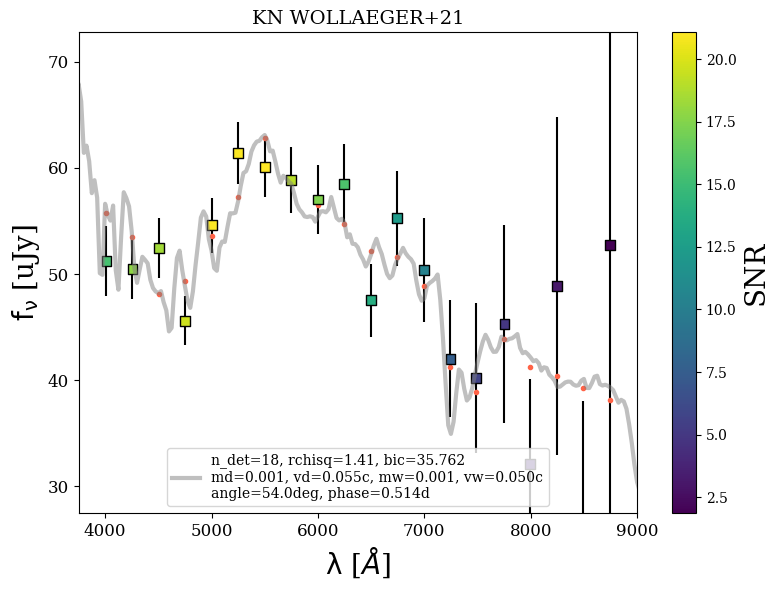

In [287]:
plt.close('all')
plt.figure(figsize=(8, 6))
plt.plot(lamarr, fnuarr, c='grey', lw=3, alpha=0.5, label=label)
yl, yu = plt.ylim()
# plt.scatter(bands.effective_wavelengths, xdata, c=intbl['snr'], marker='s', s=50, ec='k')
plt.scatter(intbl['lam'], intbl['fnuobs'], c=intbl['snr'], marker='s', s=50, ec='k')
plt.errorbar(intbl['lam'], intbl['fnuobs'], yerr=intbl['fnuerr'], c='k', ls='none', zorder=0)
cbar = plt.colorbar()
cbar.set_label("SNR")
# plt.plot(bands.effective_wavelengths, func(xdata, *popt), '.', c='tomato')
plt.plot(intbl['lam'], intbl['fnu'], c='tomato', marker='.', ls='none', zorder=0)
plt.title(f"{fittype} {source.upper()}")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([3750, 9000])
plt.ylim([yl, yu])
plt.xlabel(r"$\rm \lambda$ [$\AA$]")
plt.ylabel(r"$\rm f_\nu$ [uJy]")
plt.legend(loc='lower center')
plt.tight_layout()

In [ ]:
outbl.write(outfits, overwrite=True)